The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.17.5


# The Object Detection Dataset
:label:`sec_object-detection-dataset`

There is no small dataset such as MNIST and Fashion-MNIST in the field of object detection.
In order to quickly demonstrate object detection models,
[**we collected and labeled a small dataset**].
First, we took photos of free bananas from our office
and generated
1000 banana images with different rotations and sizes.
Then we placed each banana image
at a random position on some background image.
In the end, we labeled bounding boxes for those bananas on the images.


## [**Downloading the Dataset**]

The banana detection dataset with all the image and
csv label files can be downloaded directly from the Internet.


In [1]:
%matplotlib inline
import os
import pandas as pd
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

npx.set_np()

In [2]:
#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

## Reading the Dataset

We are going to [**read the banana detection dataset**] in the `read_data_bananas`
function below.
The dataset includes a csv file for
object class labels and
ground-truth bounding box coordinates
at the upper-left and lower-right corners.


In [3]:
#@save
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(image.imread(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, np.expand_dims(np.array(targets), 1) / 256

By using the `read_data_bananas` function to read images and labels,
the following `BananasDataset` class
will allow us to [**create a customized `Dataset` instance**]
for loading the banana detection dataset.


In [4]:
#@save
class BananasDataset(gluon.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].astype('float32').transpose(2, 0, 1),
                self.labels[idx])

    def __len__(self):
        return len(self.features)

Finally, we define
the `load_data_bananas` function to [**return two
data iterator instances for both the training and test sets.**]
For the test dataset,
there is no need to read it in random order.


In [5]:
#@save
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = gluon.data.DataLoader(BananasDataset(is_train=True),
                                       batch_size, shuffle=True)
    val_iter = gluon.data.DataLoader(BananasDataset(is_train=False),
                                     batch_size)
    return train_iter, val_iter

Let us [**read a minibatch and print the shapes of
both images and labels**] in this minibatch.
The shape of the image minibatch,
(batch size, number of channels, height, width),
looks familiar:
it is the same as in our earlier image classification tasks.
The shape of the label minibatch is
(batch size, $m$, 5),
where $m$ is the largest possible number of bounding boxes
that any image has in the dataset.

Although computation in minibatches is more efficient,
it requires that all the image examples
contain the same number of bounding boxes to form a minibatch via concatenation.
In general,
images may have a varying number of bounding boxes;
thus,
images with fewer than $m$ bounding boxes
will be padded with illegal bounding boxes
until $m$ is reached.
Then
the label of each bounding box is represented by an array of length 5.
The first element in the array is the class of the object in the bounding box,
where -1 indicates an illegal bounding box for padding.
The remaining four elements of the array are
the ($x$, $y$)-coordinate values
of the upper-left corner and the lower-right corner
of the bounding box (the range is between 0 and 1).
For the banana dataset,
since there is only one bounding box on each image,
we have $m=1$.


In [6]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples


read 100 validation examples


((32, 3, 256, 256), (32, 1, 5))

## [**Demonstration**]

Let us demonstrate ten images with their labeled ground-truth bounding boxes.
We can see that the rotations, sizes, and positions of bananas vary across all these images.
Of course, this is just a simple artificial dataset.
In practice, real-world datasets are usually much more complicated.


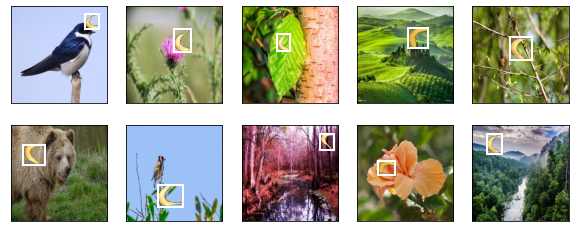

In [7]:
imgs = (batch[0][0:10].transpose(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Summary

* The banana detection dataset we collected can be used to demonstrate object detection models.
* The data loading for object detection is similar to that for image classification. However, in object detection the labels also contain information of ground-truth bounding boxes, which is missing in image classification.


## Exercises

1. Demonstrate other images with ground-truth bounding boxes in the banana detection dataset. How do they differ with respect to bounding boxes and objects?
1. Say that we want to apply data augmentation, such as random cropping, to object detection. How can it be different from that in image classification? Hint: what if a cropped image only contains a small portion of an object?


[Discussions](https://discuss.d2l.ai/t/372)
